## X-Ray Abnormality Detection with CNNs

> **Antonopoulos Ilias** ( *p3352004* ) <br />
> **Ndoja Silva** ( *p3352017* ) <br />
> **MSc in Data Science, AUEB**

## Table of Contents

- [Data Loading](#Data-Loading)
 * [Create a tensorflow input pipeline for the training data](#Create-a-tensorflow-input-pipeline-for-the-training-data)
 * [Create a tensorflow input pipeline for the testing data](#Create-a-tensorflow-input-pipeline-for-the-testing-data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Baseline Performance](#Baseline-Performance)
 * [Random Classification](#Random-Classification)
 * [Using a simple CNN architecture](#Using-a-simple-CNN-architecture)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [1]:
import gc
import itertools
import os
import pathlib
import random
import re
from glob import glob
from PIL import Image
from typing import Iterable


import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import image
from plotnine import *
from sklearn.metrics import cohen_kappa_score, confusion_matrix


pd.set_option("max_colwidth", None)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-03-26 13:25:42.284131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 13:25:42.315113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 13:25:42.315292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [4]:
SEED = 1234567

random.seed(SEED)

In [5]:
print(tf.__version__)

2.8.0


### Data Loading

In [6]:
DATASET_DIR = "data/MURA-v1.1/"

In [7]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [8]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['data/MURA-v1.1/valid/XR_SHOULDER/patient11267/study2_negative/image3.png',
 'data/MURA-v1.1/train/XR_FINGER/patient04852/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_SHOULDER/patient01627/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_FINGER/patient04677/study1_negative/image1.png',
 'data/MURA-v1.1/valid/XR_SHOULDER/patient11758/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_HUMERUS/patient03167/study1_negative/image4.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient05507/study1_negative/image4.png',
 'data/MURA-v1.1/train/XR_SHOULDER/patient00147/study1_positive/image2.png',
 'data/MURA-v1.1/train/XR_HUMERUS/patient03043/study1_negative/image2.png',
 'data/MURA-v1.1/train/XR_WRIST/patient02868/study1_negative/image1.png']

In [9]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <data/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them and undestand their structure. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [10]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [11]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [12]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [13]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [14]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [15]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [16]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [17]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [18]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    #     rotation_range=30,
    #     brightness_range=None,
    #     shear_range=0.2,
    #     zoom_range=0.2,
    #     horizontal_flip=True,
    #     fill_mode="constant",
    #     cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.2,
)

In [19]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 29447 validated image filenames belonging to 2 classes.


In [20]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    subset="validation",
)

Found 7361 validated image filenames belonging to 2 classes.


#### Create a tensorflow input pipeline for the testing data

In [21]:
test_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

In [22]:
test_image_paths["image_path"] = test_image_paths["image_path"].map(
    lambda x: os.path.join("data/", x)
)
test_image_paths["study_type"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
test_image_paths["patient"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
test_image_paths["study"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
test_image_paths["study_path"] = test_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [23]:
test_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

In [24]:
test_labeled_studies["study_path"] = test_labeled_studies["study_path"].map(
    lambda x: os.path.join("data/", x)
)
test_labeled_studies["label"] = test_labeled_studies["label"].map(str)

In [25]:
ref_testset = pd.merge(
    test_image_paths, test_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_testset)

shape: (3197, 6)


,image_path,study_type,patient,study,study_path,label
0,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,XR_WRIST,patient11185,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,XR_WRIST,patient11185,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
2,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,XR_WRIST,patient11185,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
3,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,XR_WRIST,patient11185,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
4,data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,XR_WRIST,patient11186,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1


In [26]:
testing = tf.keras.preprocessing.image.ImageDataGenerator(
    #     rotation_range=30,
    #     brightness_range=None,
    #     shear_range=0.2,
    #     zoom_range=0.2,
    #     horizontal_flip=True,
    #     fill_mode="constant",
    #     cval=0.0,
    rescale=1.0
    / 255,
)

In [27]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
)

Found 3197 validated image filenames belonging to 2 classes.


### Exploratory Data Analysis

Each study contains one or more views (images) and is labeled as either normal or abnormal.

The training dataset consists of `13457` studies with a total of `36808` images.

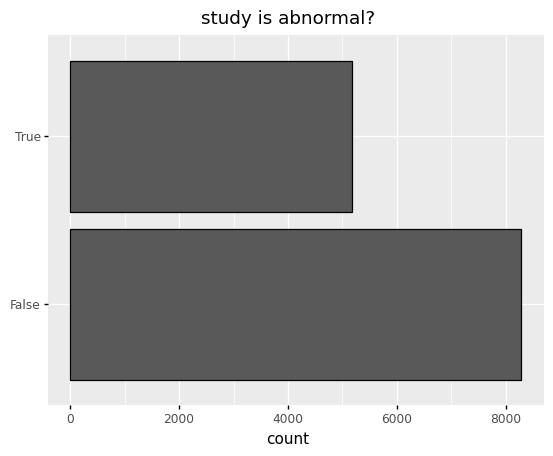

<ggplot: (8729119191580)>

In [28]:
abnormal = train_labeled_studies["label"] == "1"

(
    ggplot()
    + geom_bar(mapping=aes(x=abnormal), colour="black")
    + labs(title="study is abnormal?", x="")
    + coord_flip()
)

We have in our hands an imbalanced dataset.

In [29]:
majority_class_size, minority_class_size = abnormal.value_counts().values
imbalance_ratio = round(minority_class_size / majority_class_size, 3)

print(
    f"The imbalance ratio (minority class size / majority class size) is: {imbalance_ratio}"
)

The imbalance ratio (minority class size / majority class size) is: 0.625


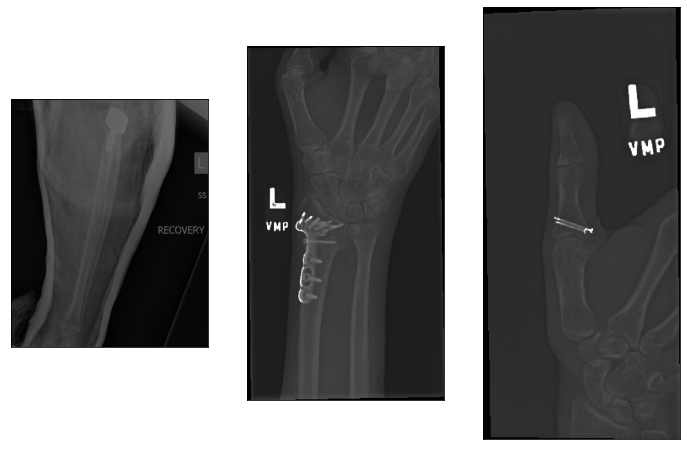

In [30]:
ax = []
fig = plt.figure(figsize=(12, 12))
positive_sample = (
    ref_trainset[ref_trainset["image_path"].str.contains("positive")]["image_path"]
    .sample(3, random_state=SEED)
    .values
)

for ix, path in enumerate(positive_sample):
    img = image.imread(path)
    ax.append(fig.add_subplot(1, 3, ix + 1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.show()

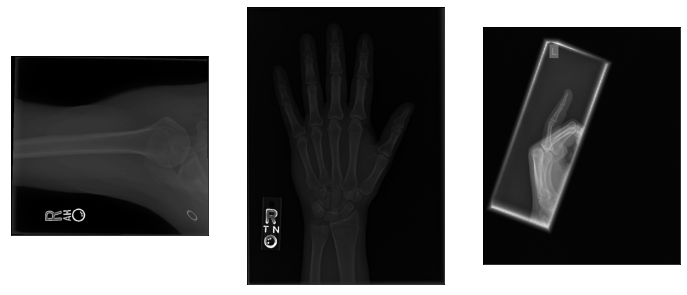

In [31]:
ax = []
fig = plt.figure(figsize=(12, 12))
negative_sample = (
    ref_trainset[ref_trainset["image_path"].str.contains("negative")]["image_path"]
    .sample(3, random_state=SEED)
    .values
)

for ix, path in enumerate(negative_sample):
    img = image.imread(path)
    ax.append(fig.add_subplot(1, 3, ix + 1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.show()

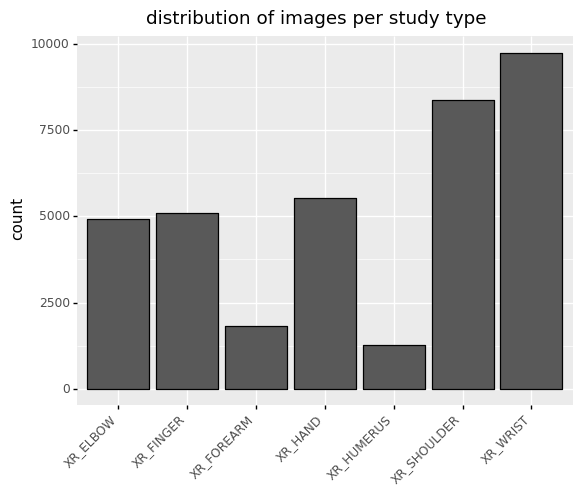

<ggplot: (8729119040199)>

In [32]:
(
    ggplot(ref_trainset)
    + geom_bar(aes(x="study_type"), colour="black")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="", y="count", title="distribution of images per study type")
)

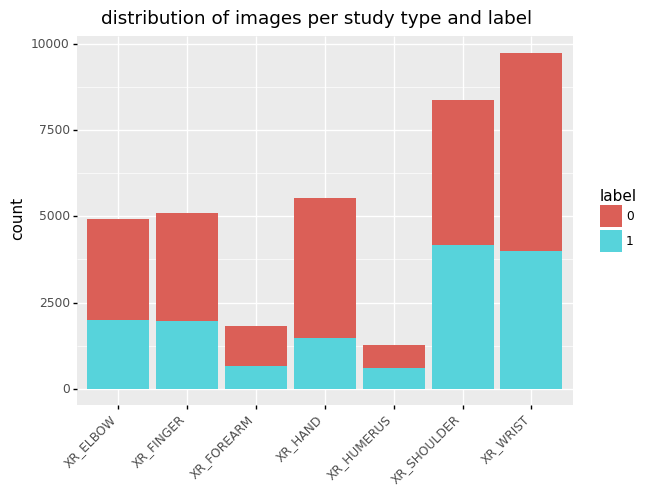

<ggplot: (8729118983428)>

In [33]:
(
    ggplot(ref_trainset.groupby(["study_type", "label"]))
    + geom_bar(aes(x="study_type", fill="label"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="", y="count", title="distribution of images per study type and label")
)

In [34]:
classes = ref_trainset["study_type"].unique()

for klass in classes:

    majority, minority = (
        ref_trainset.groupby(["study_type", "label"])["study_type"].count().loc[(klass)]
    )

    print(
        f"study type: {klass + ' ' * (11 - len(klass))}  |  imbalance ratio: {round(minority / majority, 3)}"
    )

study type: XR_SHOULDER  |  imbalance ratio: 0.99
study type: XR_HUMERUS   |  imbalance ratio: 0.89
study type: XR_FINGER    |  imbalance ratio: 0.627
study type: XR_ELBOW     |  imbalance ratio: 0.686
study type: XR_WRIST     |  imbalance ratio: 0.692
study type: XR_FOREARM   |  imbalance ratio: 0.568
study type: XR_HAND      |  imbalance ratio: 0.366


We can observe that the `XR_SHOULDER` study type is a balanced "sub-dataset" w.r.t abnormality.

The other study types exhibit different ratios of imbalance, with the most imbalance type being `XR_HAND`.

In [35]:
# TODO: plot the average number of views (aka images) per study type - perhaps boxplots?

### Baseline Performance

#### Random Classification

In [36]:
class RandomClassifier(object):
    """Random classifier - predicts whether an image is normal or abnormal at random."""

    def predict(self, image_path: str) -> int:

        return 1 if random.random() > 0.5 else 0

In [37]:
temp_testset = ref_testset.copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [38]:
model = RandomClassifier()

temp_testset["prediction"] = temp_testset["image_path"].map(model.predict)

In [39]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

-0.012701184642522234

We now have to aggregate all the predictions - in a meaningful way - at the study level.

We will assume that if the majority of the images of a given study are classified as abnormal, then the study will be classified as abnormal as well (and vice versa).

In [40]:
def study_oriented_transformation(dataset: pd.DataFrame) -> Iterable:

    for study, group in dataset.groupby("study_path"):

        yield study, group["label"].values.take(0), np.bincount(
            group["prediction"].values
        ).argmax()

In [41]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [42]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

-0.02845254944914255

#### Using a simple CNN architecture

In [43]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [44]:
# the tfa.metrics.F1Score (https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score)
# requires some reshaping that is inconsistent with the other metrics we like to track
# so we will define it from scratch

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [45]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(num_classes=2),
]

2022-03-26 13:25:46.137298: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 13:25:46.138736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 13:25:46.138946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 13:25:46.139069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [46]:
def plot_metrics(history):

    plt.rcParams["figure.figsize"] = (12, 10)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    metrics = ["loss", "f1_score", "precision", "recall"]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label="Train")
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[0],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])

        plt.legend();

In [47]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.PuBuGn
):

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = [11, 9]
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [48]:
def make_cnn_model():
    """Creates a CNN architecture with sensible defaults."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="2nd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=32,
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [49]:
model = make_cnn_model()

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 224, 224, 64)      1792      
                                                                 
 1st-max-pooling (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 1st-dropout (Dropout)       (None, 112, 112, 64)      0         
                                                                 
 2nd-convolution (Conv2D)    (None, 112, 112, 32)      18464     
                                                                 
 2nd-max-pooling (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 2nd-dropout (Dropout)       (None, 56, 56, 32)        0

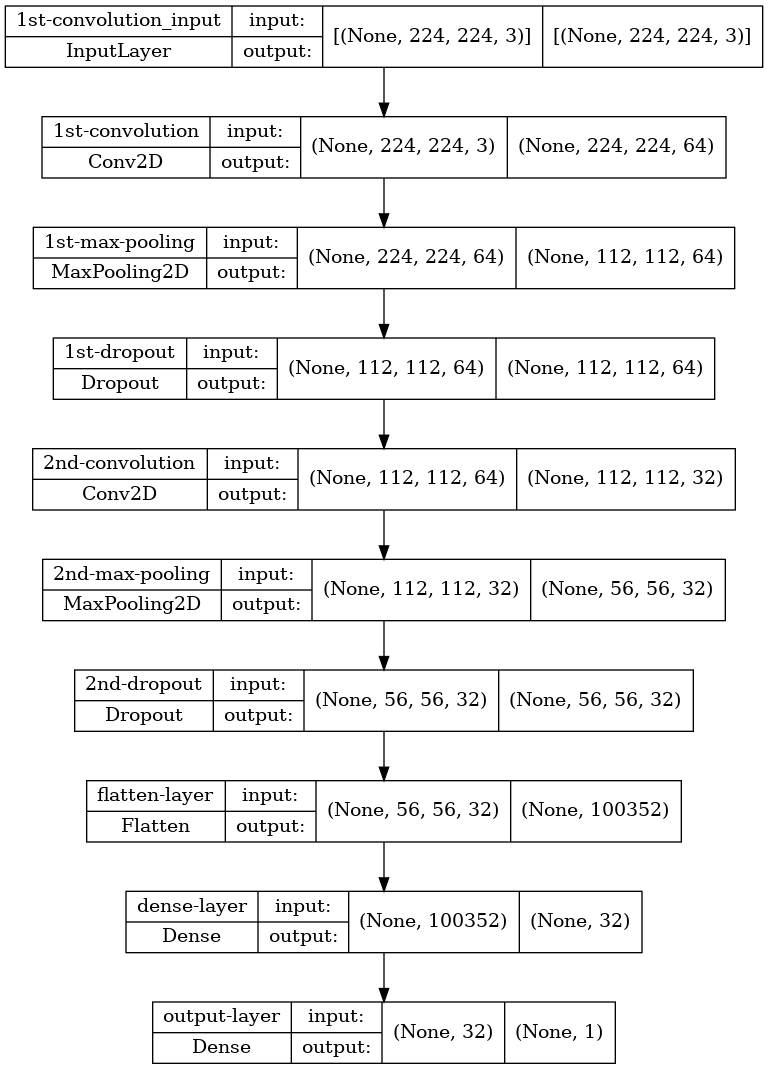

In [60]:
tf.keras.utils.plot_model(
    model,
    to_file="static/mura-cnn-all-study-types-3231585.png",
    show_shapes=True,
    show_layer_names=True,
)

In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1,
    patience=20,
    mode="max",
)

In [53]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, verbose=1, patience=5, min_lr=1e-6
)

In [54]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100


2022-03-26 13:25:50.337242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-03-26 13:25:51.488247: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-26 13:25:51.488288: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-26 13:25:52.760583: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

921/921 [==============================] - 164s 172ms/step - loss: 0.8938 - tp: 145.0000 - fp: 152.0000 - tn: 18590.0000 - fn: 10560.0000 - binary_acc: 0.6362 - precision: 0.4882 - recall: 0.0135 - f1_score: 0.0264 - roc_auc: 0.5972 - pr_auc: 0.4361 - cohen_kappa: 0.0069 - val_loss: 0.8601 - val_tp: 18.0000 - val_fp: 2.0000 - val_tn: 3191.0000 - val_fn: 4150.0000 - val_binary_acc: 0.4359 - val_precision: 0.9000 - val_recall: 0.0043 - val_f1_score: 0.0086 - val_roc_auc: 0.5267 - val_pr_auc: 0.5869 - val_cohen_kappa: 0.0032 - lr: 1.0000e-04
Epoch 2/100
921/921 [==============================] - 153s 166ms/step - loss: 0.6903 - tp: 238.0000 - fp: 170.0000 - tn: 18572.0000 - fn: 10467.0000 - binary_acc: 0.6388 - precision: 0.5833 - recall: 0.0222 - f1_score: 0.0428 - roc_auc: 0.6226 - pr_auc: 0.4686 - cohen_kappa: 0.0166 - val_loss: 0.8314 - val_tp: 7.0000 - val_fp: 2.0000 - val_tn: 3191.0000 - val_fn: 4161.0000 - val_binary_acc: 0.4345 - val_precision: 0.7778 - val_recall: 0.0017 - val_f1

921/921 [==============================] - 136s 148ms/step - loss: 0.6300 - tp: 1899.0000 - fp: 1118.0000 - tn: 17624.0000 - fn: 8806.0000 - binary_acc: 0.6630 - precision: 0.6294 - recall: 0.1774 - f1_score: 0.2768 - roc_auc: 0.6648 - pr_auc: 0.5253 - cohen_kappa: 0.1392 - val_loss: 0.8295 - val_tp: 63.0000 - val_fp: 34.0000 - val_tn: 3159.0000 - val_fn: 4105.0000 - val_binary_acc: 0.4377 - val_precision: 0.6495 - val_recall: 0.0151 - val_f1_score: 0.0295 - val_roc_auc: 0.5200 - val_pr_auc: 0.5819 - val_cohen_kappa: 0.0039 - lr: 2.0000e-05
Epoch 16/100
921/921 [==============================] - 137s 149ms/step - loss: 0.6288 - tp: 2029.0000 - fp: 1201.0000 - tn: 17541.0000 - fn: 8676.0000 - binary_acc: 0.6646 - precision: 0.6282 - recall: 0.1895 - f1_score: 0.2912 - roc_auc: 0.6674 - pr_auc: 0.5282 - cohen_kappa: 0.1475 - val_loss: 0.8517 - val_tp: 64.0000 - val_fp: 30.0000 - val_tn: 3163.0000 - val_fn: 4104.0000 - val_binary_acc: 0.4384 - val_precision: 0.6809 - val_recall: 0.0154 - 

921/921 [==============================] - 136s 147ms/step - loss: 0.6240 - tp: 2382.0000 - fp: 1336.0000 - tn: 17406.0000 - fn: 8323.0000 - binary_acc: 0.6720 - precision: 0.6407 - recall: 0.2225 - f1_score: 0.3303 - roc_auc: 0.6787 - pr_auc: 0.5420 - cohen_kappa: 0.1758 - val_loss: 0.8924 - val_tp: 53.0000 - val_fp: 27.0000 - val_tn: 3166.0000 - val_fn: 4115.0000 - val_binary_acc: 0.4373 - val_precision: 0.6625 - val_recall: 0.0127 - val_f1_score: 0.0250 - val_roc_auc: 0.5249 - val_pr_auc: 0.5864 - val_cohen_kappa: 0.0037 - lr: 1.0000e-06
Epoch 29/100
921/921 [==============================] - 136s 147ms/step - loss: 0.6240 - tp: 2413.0000 - fp: 1377.0000 - tn: 17365.0000 - fn: 8292.0000 - binary_acc: 0.6716 - precision: 0.6367 - recall: 0.2254 - f1_score: 0.3329 - roc_auc: 0.6784 - pr_auc: 0.5422 - cohen_kappa: 0.1764 - val_loss: 0.8830 - val_tp: 55.0000 - val_fp: 30.0000 - val_tn: 3163.0000 - val_fn: 4113.0000 - val_binary_acc: 0.4372 - val_precision: 0.6471 - val_recall: 0.0132 - 

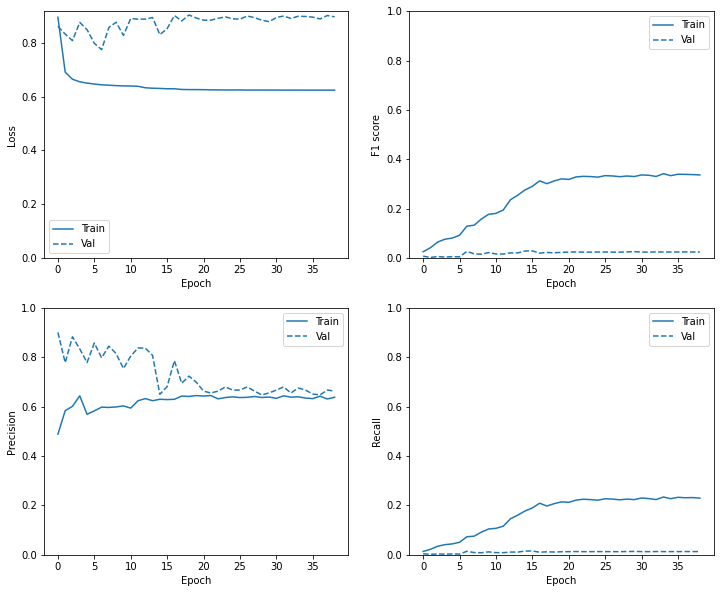

In [55]:
plot_metrics(history)

In [56]:
metrics = model.evaluate(testset, verbose=1)

100/100 [==============================] - 9s 90ms/step - loss: 0.7180 - tp: 234.0000 - fp: 123.0000 - tn: 1544.0000 - fn: 1296.0000 - binary_acc: 0.5561 - precision: 0.6555 - recall: 0.1529 - f1_score: 0.2480 - roc_auc: 0.6189 - pr_auc: 0.6012 - cohen_kappa: 0.0817


In [57]:
loss = metrics.pop(0)

In [58]:
print(f"test loss   : {loss}")
for metric, score in zip(METRICS, metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 0.718004047870636
tp          : 234.0
fp          : 123.0
tn          : 1544.0
fn          : 1296.0
binary_acc  : 0.5561463832855225
precision   : 0.6554622054100037
recall      : 0.15294118225574493
f1_score    : 0.2480127364397049
roc_auc     : 0.6188948750495911
pr_auc      : 0.6011673212051392
cohen_kappa : 0.08173078298568726


In [59]:
# model naming convention: 
# {dataset}-{architecture}-{which-study-type?}-{num-parameters}.h5
model.save("models/mura-cnn-all-study-types-3231585.h5")

In [ ]:
clean_up(model)

### Hyperparameter Tuning

In [ ]:
def cnn_model_builder(hp):
    """Creates a HyperModel instance (or callable that takes hyperparameters and returns a Model instance)."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=hp.Int("1st-filter", min_value=32, max_value=128, step=16),
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(128, 128, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=hp.Float("1st-dropout", min_value=0.0, max_value=0.4, step=0.1),
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=hp.Int("2nd-filter", min_value=32, max_value=64, step=16),
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=hp.Float("2nd-dropout", min_value=0.0, max_value=0.4, step=0.1),
                name="2nd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=hp.Int("dense-layer-units", min_value=32, max_value=128, step=16),
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice(
                "learning-rate", values=[1e-3, 1e-4, 2 * 1e-4, 4 * 1e-4]
            )
        ),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [ ]:
# Li, Lisha, and Kevin Jamieson.
# "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization."
# Journal of Machine Learning Research 18 (2018): 1-52.
# https://jmlr.org/papers/v18/16-558.html
tuner = kt.Hyperband(
    cnn_model_builder,
    objective=kt.Objective("val_prc", direction="max"),
    max_epochs=50,  # the maximum number of epochs to train one model
    seed=SEED,
    directory="hparam-tuning",
    project_name="cnn",
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(
    trainset,
    validation_data=validationset,
    epochs=50,
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping],
)

# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. \n

Results
=======
|
---- optimal number of output filters in the 1st convolution : {best_hps.get('1st-filter')}
|
---- optimal first dropout rate                              : {best_hps.get('1st-dropout')}
|
---- optimal number of output filters in the 2nd convolution : {best_hps.get('2nd-filter')}
|
---- optimal second dropout rate                             : {best_hps.get('2nd-dropout')}
|
---- optimal number of units in the densely-connected layer  : {best_hps.get('dense-layer-units')}
|
---- optimal learning rate for the optimizer                 : {best_hps.get('learning-rate')}
"""
)

### Model Selection

In [ ]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model, to_file="static/cnn_best_model.png", show_shapes=True, show_layer_names=True
)

In [ ]:
clean_up(model)

In [ ]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(
    trainset, epochs=50, validation_data=validationset, callbacks=[early_stopping]
)

In [ ]:
# keep best epoch
val_prc_per_epoch = history.history["val_prc"]
best_epoch = val_prc_per_epoch.index(max(val_prc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

In [ ]:
clean_up(hypermodel)

In [ ]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(
    trainset,
    epochs=best_epoch,
    validation_data=validationset,
    callbacks=[early_stopping],
)

### Evaluation

In [ ]:
metrics = hypermodel.evaluate(testset, verbose=1)

In [ ]:
loss = metrics.pop(0)

print(f"test loss: {loss}")
for metric, score in zip(METRICS, metrics):

    print(f"{metric.name}: {score}")

In [ ]:
Y_pred = model.predict(testset, verbose=1)

In [ ]:
Y_pred_classes = np.argmax(Y_pred, axis=1)

In [ ]:
confusion_mtx = confusion_matrix(testset.labels, Y_pred_classes)

In [ ]:
plot_confusion_matrix(
    confusion_mtx,
    classes=["normal", "abnormal"],
)